In [1]:
from scipy import *
import numpy as np
from pylab import *
from scipy.interpolate import interp1d
import os
from astropy.io import fits
%matplotlib inline

In [2]:
######## check TT, Pk (z=0), Clkk (z=1) from class vs camb

####### class
# import classy module
from classy import Class
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
A_s = 2.1e-9
OmegaB = 0.046
OmegaM = 0.3
h=0.7
n_s = 0.97
tau = 0.054
w=-1.0

LambdaCDM.set({'omega_b':OmegaB*h**2,'omega_cdm':OmegaM*h**2,'h':h,'A_s':A_s,'n_s':n_s,'tau_reio':tau})
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':10.0})
# run class
LambdaCDM.compute()

In [11]:
# get all C_l output
cls = LambdaCDM.lensed_cl(2500)
# To check the format of cls
print cls.viewkeys()

ll = cls['ell'][2:]
clTT = cls['tt'][2:]
clEE = cls['ee'][2:]
clPP = cls['pp'][2:]

# get P(k) at redhsift z=0
kk = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
Pk = [] # P(k) in (Mpc/h)**3
h = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk.append(LambdaCDM.pk(k*h,0.)*h**3) # function .pk(k,z)

dict_keys(['pp', 'ell', 'bb', 'ee', 'tt', 'tp', 'te'])


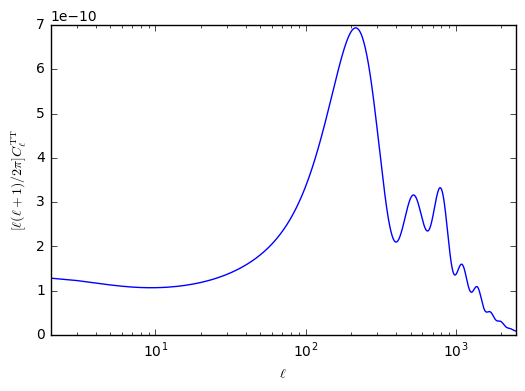

In [12]:
# plot C_l^TT
plt.figure(1)
plt.xscale('log');plt.yscale('linear');plt.xlim(2,2500)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
plt.plot(ll,clTT*ll*(ll+1)/2./pi,'b-')

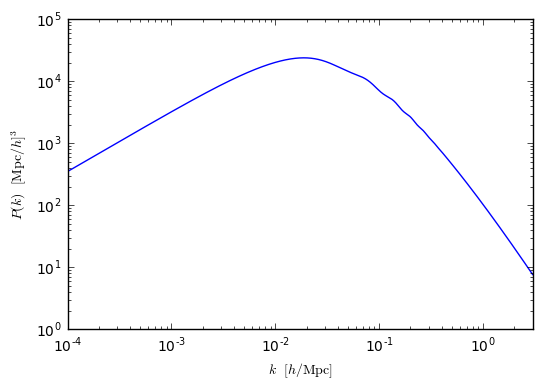

In [9]:
# plot P(k)
plt.figure(2)
plt.xscale('log');plt.yscale('log');plt.xlim(kk[0],kk[-1])
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
plt.plot(kk,Pk,'b-')